## Cloning the repository and importing required modules

Cloning the repository containing the YOLOv1 “from scratch” implementation from GitHub and navigate to the project folder.

We then import:

- YOLOv1: the YOLOv1 model class.
- yolo_loss: the YOLOv1-specific loss function.
- YoloDataset: a custom dataset class for loading YOLO images and labels.
- src.utils: various utility functions for processing and visualization.
- torch and DataLoader: for handling tensors and batching data with PyTorch.

In [16]:
!git clone https://github.com/LucasAurouet/yolov1-from-scratch.git

%cd yolov1-from-scratch

from src.yolo_model import YOLOv1
from src.loss import yolo_loss
from src.dataloader import YoloDataset
import src.utils
import torch
from torch.utils.data import DataLoader

Cloning into 'yolov1-from-scratch'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 122 (delta 76), reused 86 (delta 40), pack-reused 0 (from 0)
Receiving objects: 100% (122/122), 17.70 KiB | 8.85 MiB/s, done.
Resolving deltas: 100% (76/76), done.
/kaggle/working/yolov1-from-scratch/yolov1-from-scratch


## Setting the device for training

Checking if a GPU is available for PyTorch and set the computation device accordingly.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda


## Defining the YOLOv1 configuration

Main hyperparameters for the YOLOv1 model:

- S: the number of grid cells along each image dimension (7 × 7 grid).
- B: the number of bounding boxes predicted per grid cell (2 in this case).
- C: the number of classes in the dataset (52).

In [18]:
config = {
    'S': 7,
    'B': 2,
    'C': 52,
}

## Initializing the YOLOv1 model

Creating an instance of the YOLOv1 model using the configuration defined earlier.

YOLOv1(**config) unpacks the config dictionary and passes the hyperparameters (S, B, C).

model.to(device) moves the model to the selected computation device (GPU or CPU) so that all subsequent tensor operations and training steps occur on the correct hardware.

In [19]:
model = YOLOv1(**config)
model = model.to(device)

## Creating the dataset and visualizing an example

Initializing our custom YOLO dataset:

data_dir points to the folder containing the training images and their corresponding label files.

YoloDataset(data_dir, config) creates a dataset object that will handle loading images, reading label files, and converting annotations into YOLOv1 tensors.

We then retrieve a single example from the dataset:

example_img, example_label = dataset.\_\_getitem\_\_(0) gets the first image and its corresponding label tensor.
src.utils.draw_output displays the image along with the bounding boxes and class labels.

- The t=0.0 argument controls the threshold for drawing boxes (here set to 0 to show all boxes).
- transform=False ensures we visualize the raw image without any additional preprocessing.

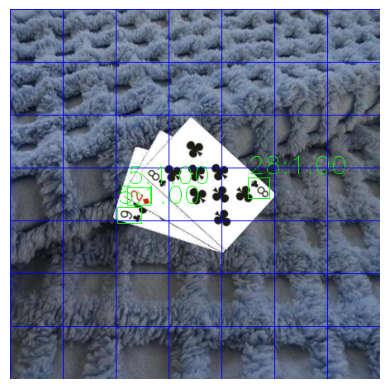

In [20]:
data_dir = r'/kaggle/input/playing-cards-darknet/train'

dataset = YoloDataset(data_dir, config)

example_img, example_label = dataset.__getitem__(0)
src.utils.draw_output(example_img, example_label, t=0.0, config=config, transform=False)

## Optimizer configuration

In [21]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=5e-4
)

## Training the YOLOv1 model

Setting up up and runnin a training loop for YOLOv1:

DataLoader wraps the YoloDataset to provide mini-batches of data with parallel loading (num_workers=4) for efficiency.

pin_memory=True can speed up GPU transfers for CUDA-enabled devices.

yolo_loss(...) calculates the YOLOv1 loss, taking into account coordinate loss (lambda_coord=5) and no-object confidence penalty (lambda_noobj=0.5).

In [28]:
epochs = 100

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

model.train()

for epoch in range(epochs):
    for images_batch, labels_batch in dataloader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        output_batch = model.forward(images_batch)
        loss = yolo_loss(output_batch, labels_batch, S=7, B=2, C=52, lambda_coord=5, lambda_noobj=0.5)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/100, Loss: 12.0203
Epoch 2/100, Loss: 10.7271
Epoch 3/100, Loss: 11.7365
Epoch 4/100, Loss: 11.3584
Epoch 5/100, Loss: 10.5494
Epoch 6/100, Loss: 10.4794
Epoch 7/100, Loss: 10.2914
Epoch 8/100, Loss: 9.9426
Epoch 9/100, Loss: 10.1970
Epoch 10/100, Loss: 10.6805
Epoch 11/100, Loss: 10.4481
Epoch 12/100, Loss: 10.6780
Epoch 13/100, Loss: 10.4673
Epoch 14/100, Loss: 10.8680
Epoch 15/100, Loss: 11.6167
Epoch 16/100, Loss: 11.3224
Epoch 17/100, Loss: 10.8219
Epoch 18/100, Loss: 11.2415
Epoch 19/100, Loss: 11.3720
Epoch 20/100, Loss: 9.9567
Epoch 21/100, Loss: 10.5386
Epoch 22/100, Loss: 10.7994
Epoch 23/100, Loss: 11.0930
Epoch 24/100, Loss: 11.1858
Epoch 25/100, Loss: 10.4986
Epoch 26/100, Loss: 10.3460
Epoch 27/100, Loss: 24.4811
Epoch 28/100, Loss: 10.9247
Epoch 29/100, Loss: 11.1019
Epoch 30/100, Loss: 11.0685
Epoch 31/100, Loss: 9.8979
Epoch 32/100, Loss: 10.2974
Epoch 33/100, Loss: 10.1918
Epoch 34/100, Loss: 10.4582
Epoch 35/100, Loss: 10.1174
Epoch 36/100, Loss: 10.2805
Epoc

KeyboardInterrupt: 

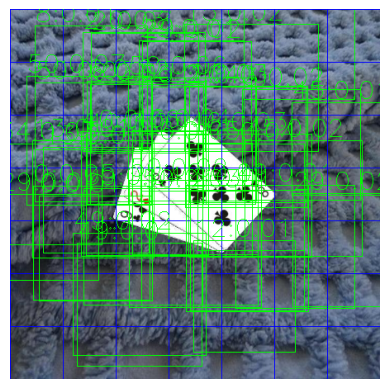

In [27]:
model.eval()
test_img, test_label = dataset.__getitem__(0)
test_tensor = test_img.unsqueeze(0).to(device)
output = model(test_tensor).squeeze(0)

src.utils.draw_output(test_img, output, t=0.0, config=config, transform=True)